# <span style="color:green"> Numerical Simulation Laboratory (NSL) Exercise 5 Results </span>

##  05.1


Use the Metropolis algorithm to sample $|\Psi_{1,0,0}(x,y,z)|^2$ and $|\Psi_{2,1,0}(x,y,z)|^2$ **in Cartesian coordinates** using, initially, an uniform transition probability $T(\vec{x}|\vec{y})$. Use the sampled positions to estimate $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$. As usual, use data blocking and give an estimate of the statistical uncertainties.

<span style="color:red">Show a picture of your estimations of $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$</span> and their uncertainties with a large number of *throws* $M$ (e.g. $M\ge 10^6$) as a function of the number of blocks, $N$</font>.

- Use Bohr radius units, $a_0$ for distances (0.0529 nm)
- Choose the step of the uniform transition probability $T(\vec{x}|\vec{y})$ in order to obtain 50% of acceptance in both cases
- Choose a reasonable starting point in the 3D space and equilibrate your sampling before to start measuring the radius. What do you observe when you start very far from the origin?
- How large should be the number of Monte Carlo Metropolis steps in each block?
- <span style="color:red">If you use a multivariate normal transition probability $T(\vec{x}|\vec{y})$, i.e. a Gaussian for each coordinate, your results for $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$ are equivalent?</span>

In [73]:
import matplotlib
import math
import subprocess
import re
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm


path = os.path.join(os.getcwd(), "hidro/")
plt.rcParams['figure.figsize'] = (15,10)

def create_input_file(r100,r210):
    with open(f"{path}/origin.dat", 'w') as new_config:
        with open(f'{path}/origin.0', 'r') as template_config:
            config = template_config.read()
            config = re.sub("{x1}", str(r100[0]), config)
            config = re.sub("{y1}", str(r100[1]), config)
            config = re.sub("{z1}", str(r100[2]), config)
            config = re.sub("{x2}", str(r210[0]), config)
            config = re.sub("{y2}", str(r210[1]), config)
            config = re.sub("{z2}", str(r210[2]), config)
            new_config.write(config)

def plot_mean(mean, err, sw, distribution):
    plt.figure(figsize=(15, 8))
    a0 = 1.#0.0529#1.
    x = np.arange(np.size(mean, 0))
    k = np.zeros(len(mean))
    k[:] = a0*3./2. # 1:, better to ignore (0,0)
    if(sw == True):
        k[:] = a0*3./2.
    if(sw == False):
        k[:] = a0*5.
    plt.errorbar(x, mean, yerr=err, fmt='.', label=r'$\left\langle r \right\rangle_{\Psi_i}$ ' + distribution, color='b')
    plt.plot(x, k, linewidth=2, color='black', label='Expected value')
    plt.xlabel('blocks')
    plt.ylabel(r'$\left\langle r \right\rangle_{\Psi_i}$ / a0')
    plt.grid(True)
    plt.legend();

def plot_mean_confront(mean_U, err_U, mean_G, err_G, sw):
    plt.figure(figsize=(15, 8))
    a0 = 1.#0.0529#1.
    x = np.arange(np.size(mean_U, 0))
    k = np.zeros(len(mean_U))
    k[:] = a0*3./2. # 1:, better to ignore (0,0)
    if(sw == True):
        k[:] = a0*3./2.
    if(sw == False):
        k[:] = a0*5.
    plt.errorbar(x, mean_U, yerr=err_U, fmt='.', label=r'$\left\langle r \right\rangle_{\Psi_i}$ uniform', color='b')
    plt.errorbar(x, mean_G, yerr=err_G, fmt='.', label=r'$\left\langle r \right\rangle_{\Psi_i}$ gauss', color='r')
    plt.plot(x, k, linewidth=2, color='black', label='Expected value')
    plt.xlabel('blocks')
    plt.ylabel(r'$\left\langle r \right\rangle_{\Psi_i}$ / a0')
    plt.grid(True)
    plt.legend();

def autocorr(x, t):
    t_max = x.size
    return ( np.dot(x[:t_max-t], x[t:t_max]) / (t_max - t) 
            - np.sum(x[:t_max-t]) * np.sum(x[t:t_max]) / (t_max - t)**2 ) /  np.var(x)

In [48]:
def autocorrelation(FORCE_NEW_RUN):
    M = 100
    steps = 4*10**3
    distribution = 0
    fig, axs = plt.subplots(2, sharex=True)
    path = os.path.join(os.getcwd(), "hidro/")
    t =np.arange(steps)
    A = np.zeros(steps)
    B = np.zeros(steps)
    
    axs[0].set_title(r'Autocorrelation $\left\langle r \right\rangle_{\Psi_{100}}$')
    axs[0].set_ylabel(r'$\chi(x)$')
    axs[0].set_xlim(0, 10**3)
    axs[1].set_title(r'Autocorrelation $\left\langle r \right\rangle_{\Psi_{210}}$')
    axs[1].set_ylabel(r'$\chi(x)$')
    axs[1].set_xlabel('number of steps')
    axs[1].set_xlim(0, 10**3)
   
    
    if FORCE_NEW_RUN:
        subprocess.run(["./main", str(M), str(steps), str(distribution)], cwd=path)
        psi100 = np.loadtxt("hidro/100.dat", unpack=True, usecols = (2))
        psi210 = np.loadtxt("hidro/210.dat", unpack=True, usecols = (2))
        A = np.vectorize(autocorr, excluded=[0])(psi100, t)
        B = np.vectorize(autocorr, excluded=[0])(psi210, t)
        np.savetxt(f'{path}/autocorrelation.dat',np.c_[A,B],delimiter=' ')
    else:
        A, B = np.loadtxt(f'{path}/autocorrelation.dat', unpack = True)
    axs[0].plot(t, A, '.')
    axs[0].axhspan(-0.1, 0.1, alpha=0.2)
    axs[0].axhline(0)
    axs[1].plot(t, B, '.')
    axs[1].axhspan(-0.1, 0.1, alpha=0.2)
    axs[1].axhline(0)

def plot(state, distribution, trows):
    if state == '100': state = True
    if state == '210': state = False
    if distribution == 'uniform': distribution = 0
    if distribution == 'gauss': distribution = 1
    M = 100
    steps = trows
    path = os.path.join(os.getcwd(), "hidro/")

    x = np.arange(10)
    ys = [i+x+(i*x)**2 for i in range(10)]

    colors = cm.rainbow(np.linspace(0, 1, len(ys)))

    subprocess.run(["./main", str(M), str(steps), str(distribution)], cwd=path)
    if state:
        x100, y100,z100 = np.loadtxt("hidro/100.dat", unpack=True, usecols = (0,1,2))
    else:
        x210, y210,z210 = np.loadtxt("hidro/210.dat", unpack=True, usecols = (0,1,2))
    plt.rcParams['figure.figsize'] = (15,10)
    fig = plt.figure()
    ax = Axes3D(fig)
    if state:
        ax.scatter(x100, y100, z100, c=z100, marker='.')
        ax.set_title(r'Autocorrelation $\left\langle r \right\rangle_{\Psi_{100}}$')
    else:
        ax.scatter(x210, y210, z210, c=z210, marker='.')
        ax.set_title(r'Autocorrelation $\left\langle r \right\rangle_{\Psi_{210}}$')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(10, 30)
    plt.show()

def plot_function_mean(state, distribution, trows):
    if state == '100': state = True
    if state == '210': state = False
    situation = distribution 
    if distribution == 'uniform': distribution = 0
    if distribution == 'gauss': distribution = 1
    M = 100
    steps = trows
    path = os.path.join(os.getcwd(), "hidro/")
    subprocess.run(["./main", str(M), str(steps), str(distribution)], cwd=path)
    if state:
        mean100, devstd100 = np.loadtxt("hidro/100rm.dat", unpack=True)
    else:
        mean210, devstd210 = np.loadtxt("hidro/210rm.dat", unpack=True)
#print(len(mean210))
    if state:
        plot_mean(mean100, devstd100, True, situation)
    else:
        plot_mean(mean210, devstd210, False, situation)

def plot_confront(state, trows):
    if state == '100': state = True
    if state == '210': state = False
    M = 100
    steps = trows
    path = os.path.join(os.getcwd(), "hidro/")
    if state:
        subprocess.run(["./main", str(M), str(steps), str(0)], cwd=path)
        mean100_U, devstd100_U = np.loadtxt("hidro/100rm.dat", unpack=True)
        subprocess.run(["./main", str(M), str(steps), str(1)], cwd=path)
        mean100_G, devstd100_G = np.loadtxt("hidro/100rm.dat", unpack=True)
    else:
        subprocess.run(["./main", str(M), str(steps), str(0)], cwd=path)
        mean210_U, devstd210_U = np.loadtxt("hidro/210rm.dat", unpack=True)
        subprocess.run(["./main", str(M), str(steps), str(1)], cwd=path)
        mean210_G, devstd210_G = np.loadtxt("hidro/210rm.dat", unpack=True)
#print(len(mean210))
    if state:
        plot_mean_confront(mean100_U, devstd100_U, mean100_G, devstd100_G, True)
    else:
        plot_mean_confront(mean210_U, devstd210_U, mean210_G, devstd210_G, False)

We present the results for $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$</span>, the step to obtain a 50% acceptance rate in the Metropolis test in both cases has been identified as:
- $A(\left\langle r \right\rangle_{\Psi_{1,0,0}}) = 0.6\times a_o$
- $A(\left\langle r \right\rangle_{\Psi_{2,1,0}}) = 6.7\times a_o$

Starting position was chosen near the origin and is encoded in file "hidro/origin.dat", in the "far away" starting position the code is unable to equilibrate the samplign and the resulting behaviour, as we'll show, $\left\langle r \right\rangle_{\Psi_{i}}$ diverge. 

To estimate how large should be the Monte Carlo Metropolis steps in each block we have estimated the autocorrelation function in the two situation, as presented by the following plots a block with $10^3$ steps is sufficient to obtain uncorrelated measurements.

In [74]:
#Chose starting position
r100 = [1,1,1]
r210 = [2,2,2]
create_input_file(r100,r210)


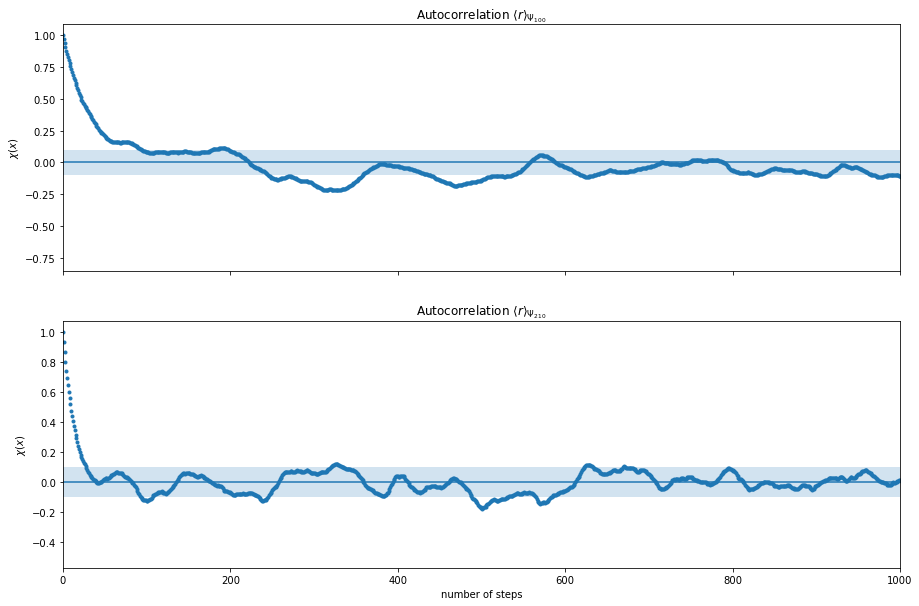

In [11]:
autocorrelation(False)

In the following plots we show the spatial distribution for the sampled points and radial distribution with block method with numbers of block $10^2$ and numbers of steps $10^6$. This means $10^4$ steps for each blocks are sufficient for uncorrelated measurments.

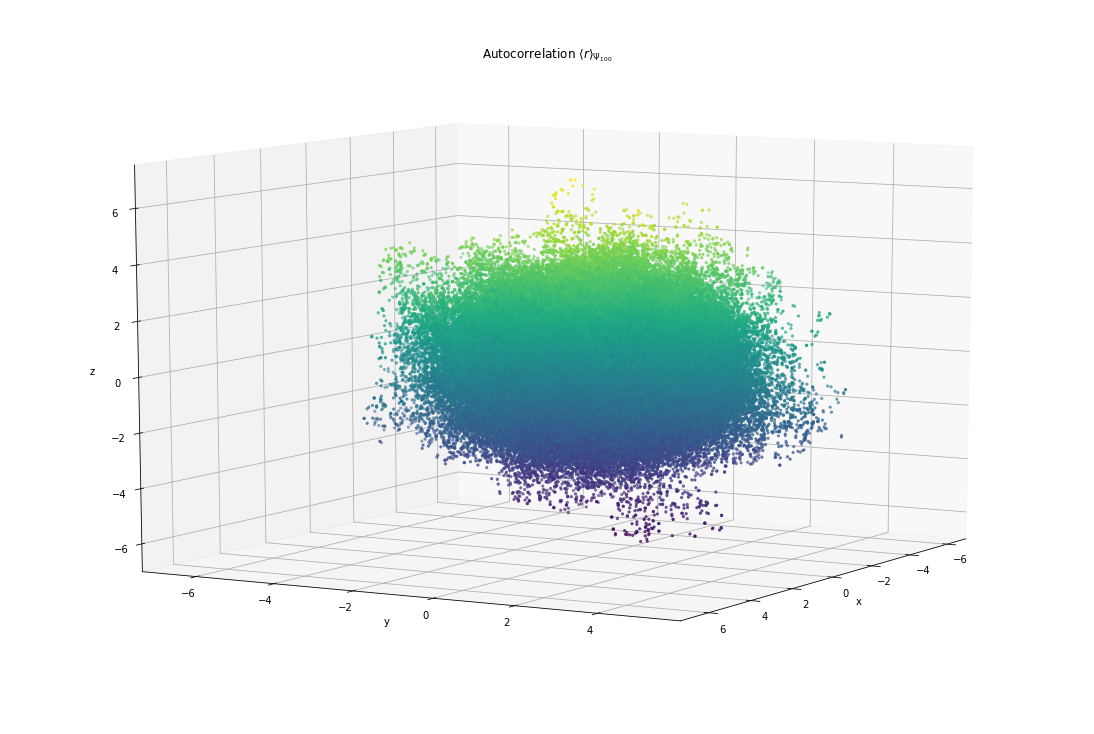

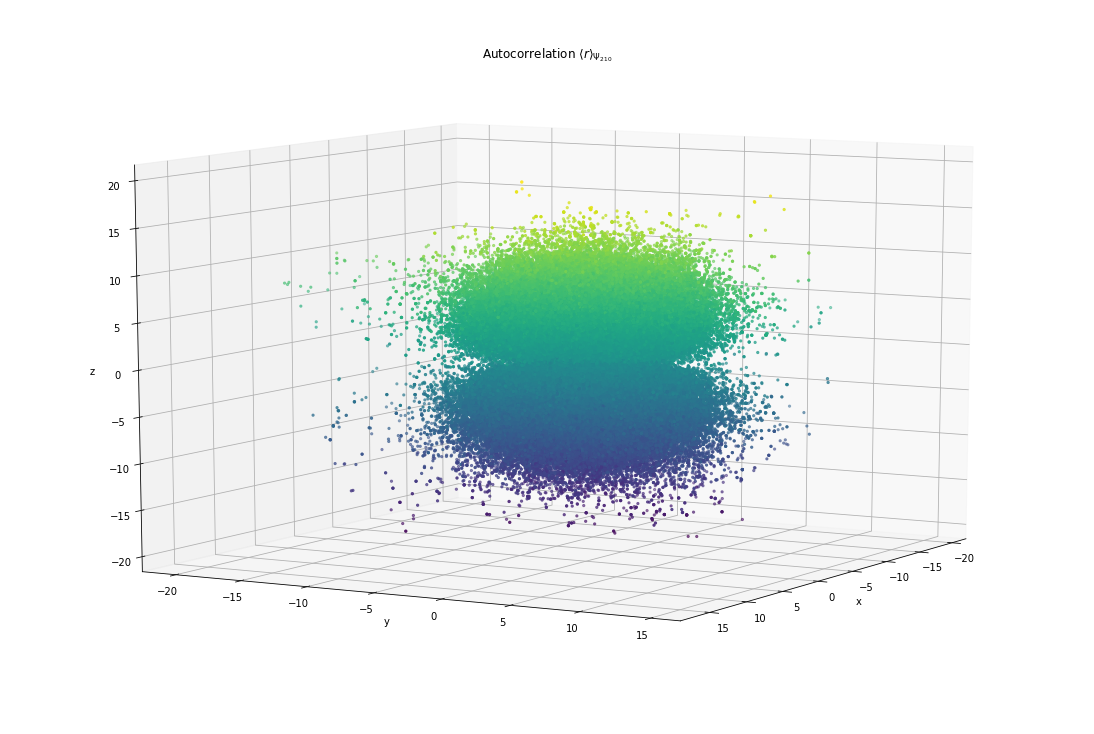

In [26]:
plot('100','uniform',1000000)
plot('210','uniform',1000000)

As depicted by the two evaluation in the first scenario ($\left\langle r \right\rangle_{\Psi_{1,0,0}}$) the expected value fall within one $\sigma$ from our extimation. The same cannot be said in the $\left\langle r \right\rangle_{\Psi_{2,1,0}}$</span>  case where the expected result fall far away from our best extimation.

As shown the error bars dimension in the two extimation are very different, which make us wonder in a bug in our code, probably an oversight error, that hasn't been identified yet.

Serching the above error produced a really bad and unpolish code that we're sorry to present.

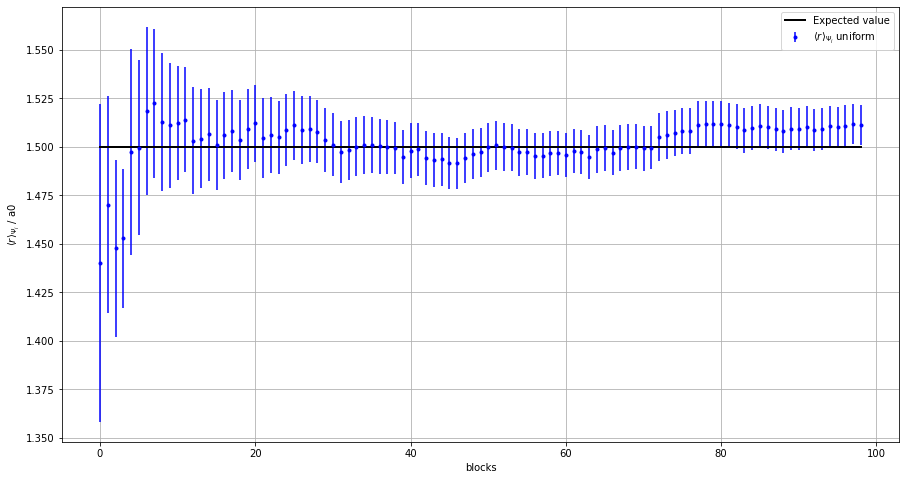

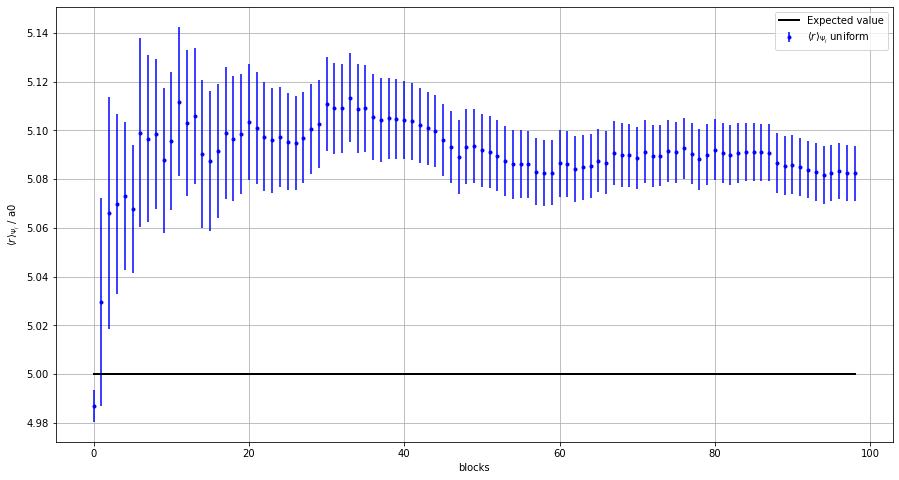

In [24]:
plot_function_mean('100', 'uniform',1000000)
plot_function_mean('210', 'uniform',1000000)

As last we exhibit two plots with both gaussian and uniform sampling estimation with the above choises for numbers of blocks and steps.

With the gaussian transition probability we have a reduced uncertainty, in this case both the extimation fall within few $\sigma$ from the real value. As stated in this instance the  $\left\langle r \right\rangle_{\Psi_{1,0,0}}$</span> extimation results are worst than the uniform sampling extimation.

As in the above situation we are not completely sure if our extimation is really without code errors.

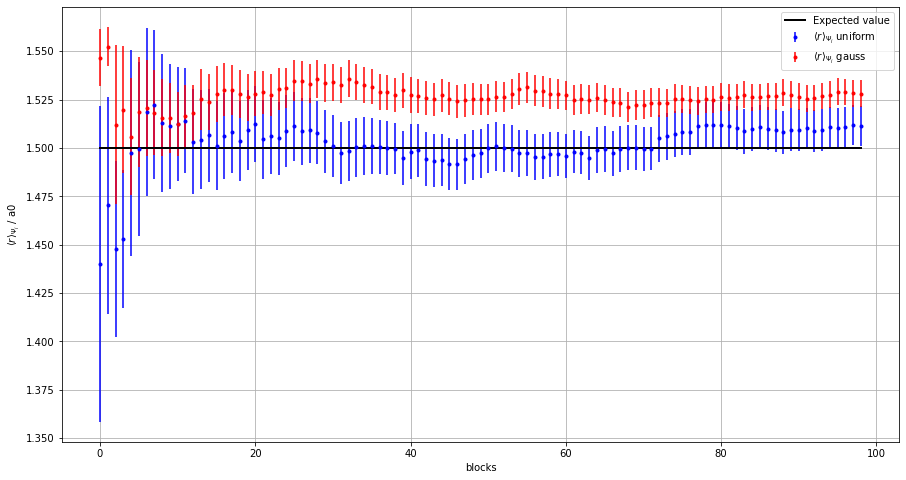

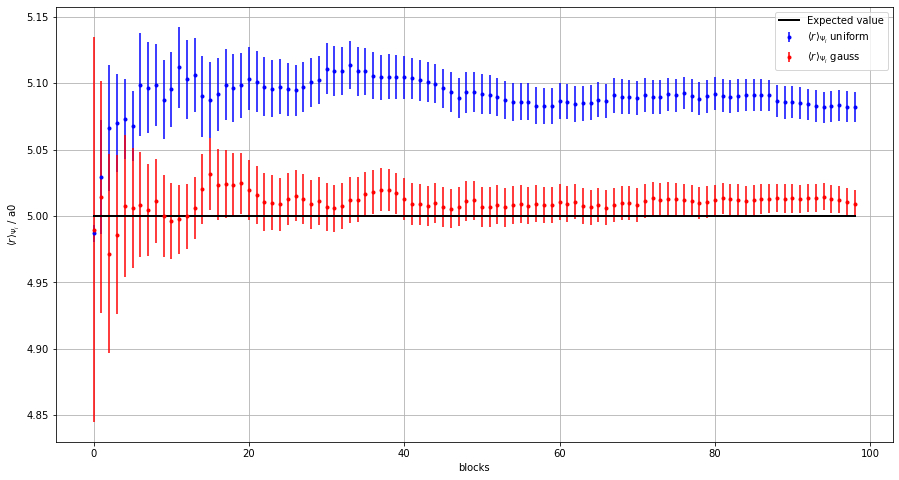

In [25]:
plot_confront('100',1000000)
plot_confront('210',1000000)

$\renewcommand{\vec}[1]{\mathbf{#1}}$
## Far from the origin
When starting very far from the origin, i.e., $\vec{x}_0\;|\; \lVert \vec{x}_0\rVert\gg0$, diverges.
- For the  $\left\langle r \right\rangle_{\Psi_{1,0,0}}$</span> when position is further then for example $\vec{r}$ = {210,210,210} in the uniform case.
- For the  $\left\langle r \right\rangle_{\Psi_{2,1,0}}$</span> when position is further then, for example $\vec{r}$ = {425,425,425} also here in the uniform case, the gaussian occurence requires a further position to diverge 

Previous to that point our result converges to the previous one as presented in the following scatterplots and radial function block extimations in the uniform and gaussian case. In the gaussian instance the convergences is easily aquired.

We show some example below

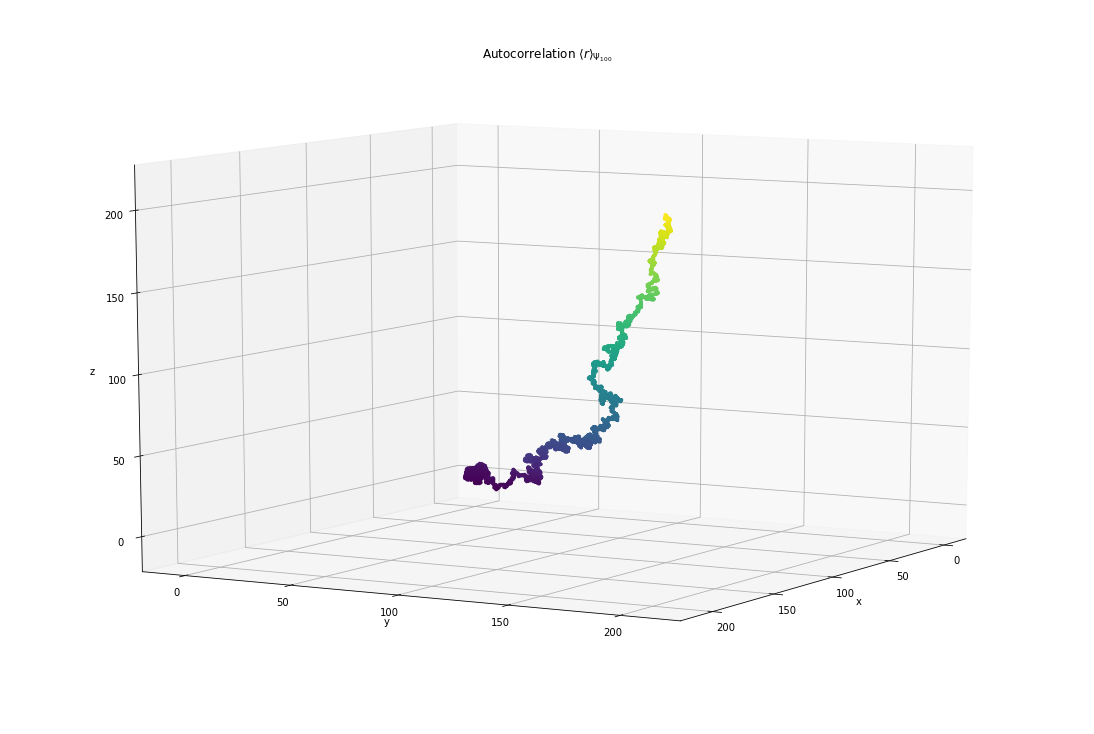

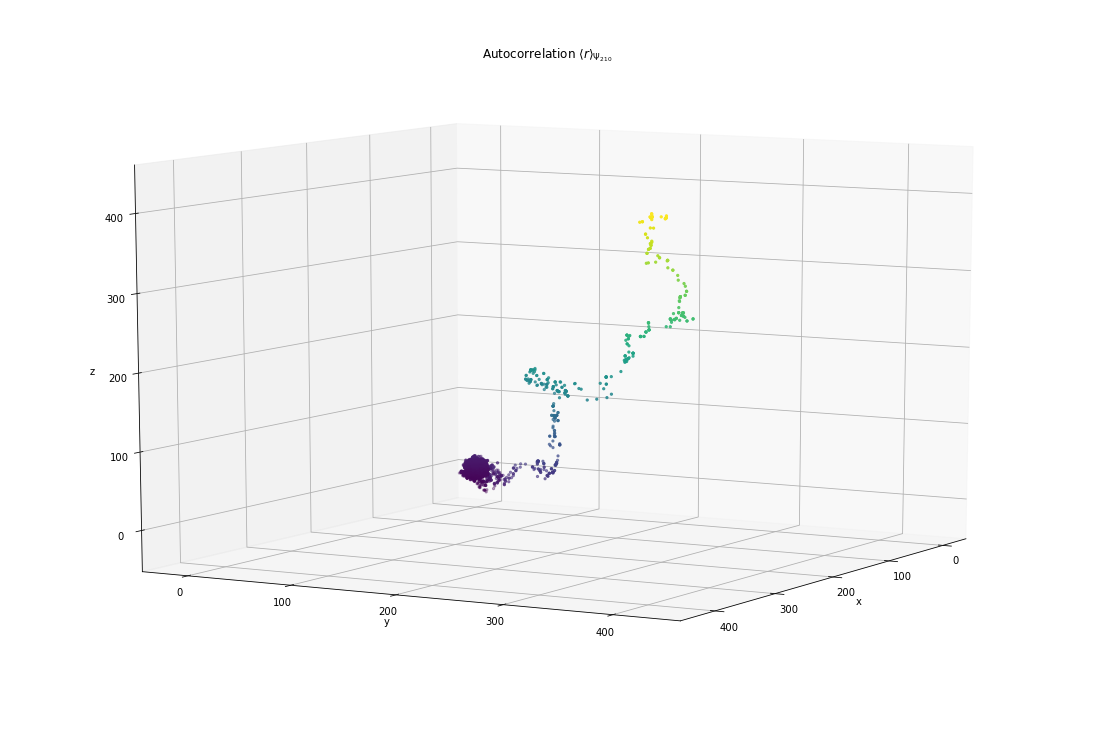

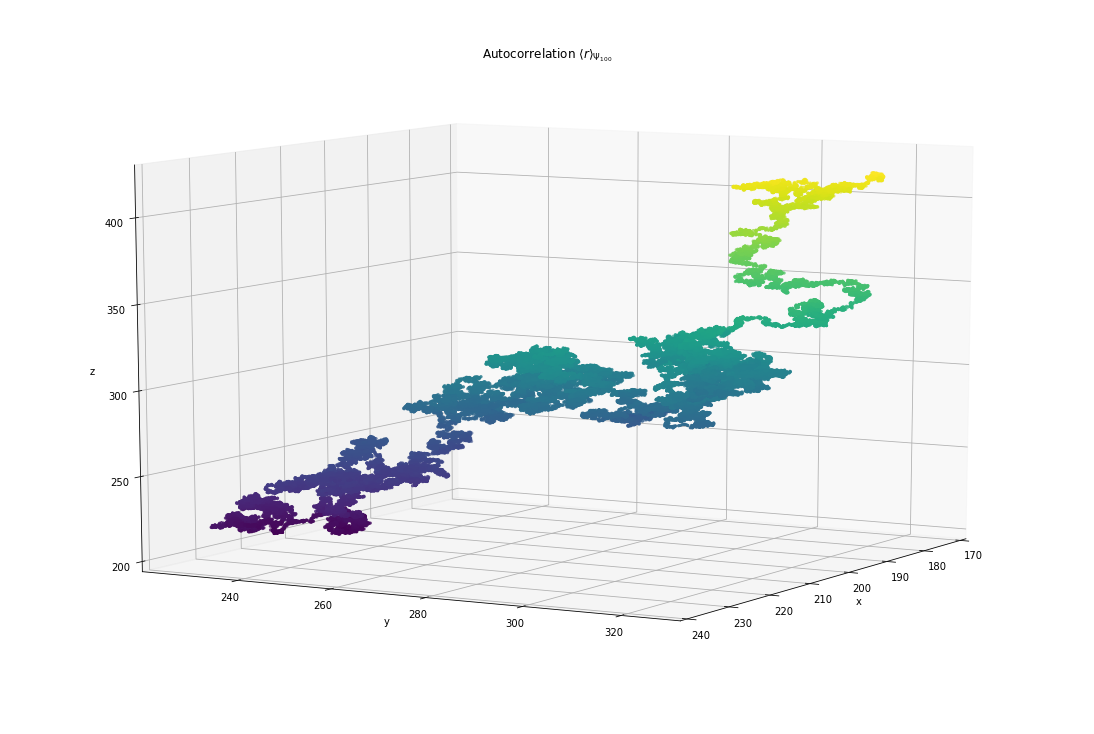

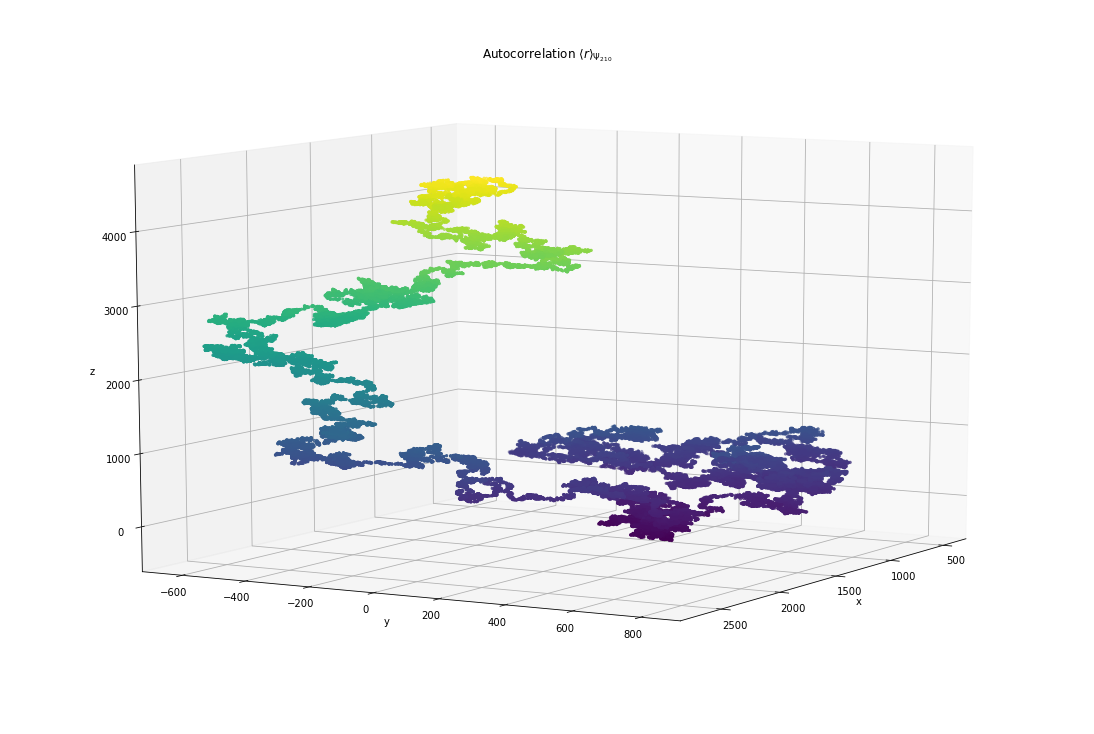

In [72]:
r100 = [210,210,210]
r210 = [425,425,425]
create_input_file(r100,r210)

plot('100','uniform', 100000)
plot('210','gauss', 100000)
r100 = [230,230,230]
r210 = [600,600,600]
create_input_file(r100,r210)
plot('100','uniform', 100000)
plot('210','gauss', 100000)

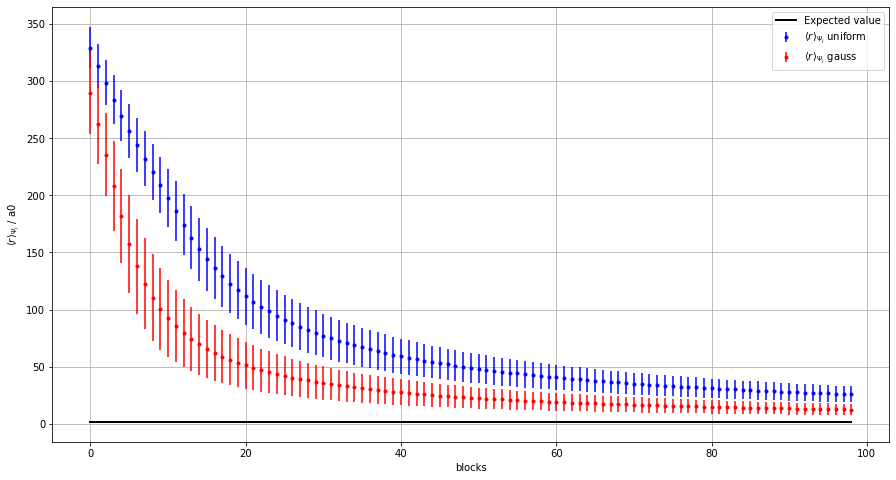

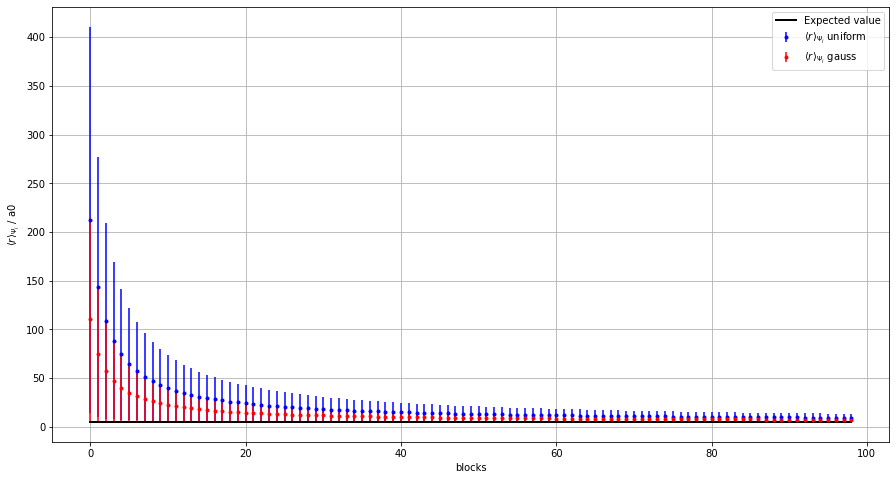

In [69]:
plot_confront('100',100000)
plot_confront('210',100000)